Download dataset

Required dependencies

In [ ]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm

Looking in indexes: https://test.pypi.org/simple/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision
import transformers
import pytorch_lightning

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121
roboflow: 1.1.49 ; supervision: 0.3.0 ; transformers: 4.46.3 ; pytorch_lightning: 2.4.0


Load Pretrained Model

In [ ]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

Inference using pretrained model


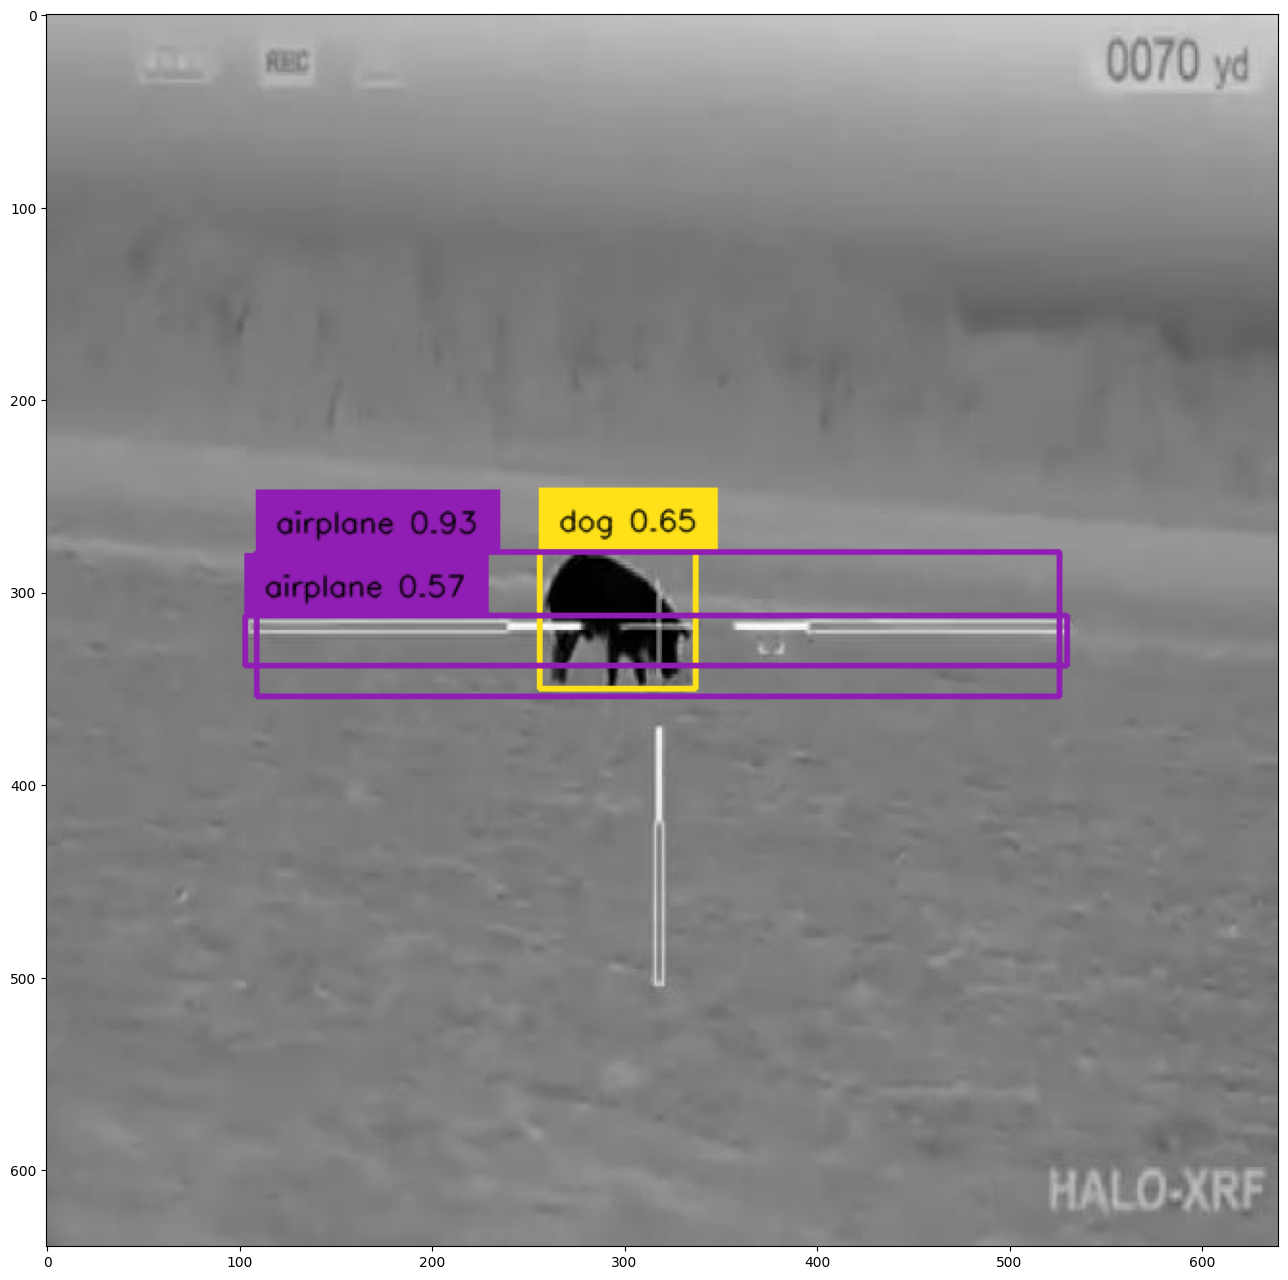

In [ ]:
import cv2
import torch
import supervision as sv


with torch.no_grad():

    # load image and predict
    image = cv2.imread("/content/Thermal-Image-detection-1/test/frame112_png.rf.674a48b3f3d0b6522eed3297d63a1a80.jpg")
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results)

labels = [
    f"{model.config.id2label[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

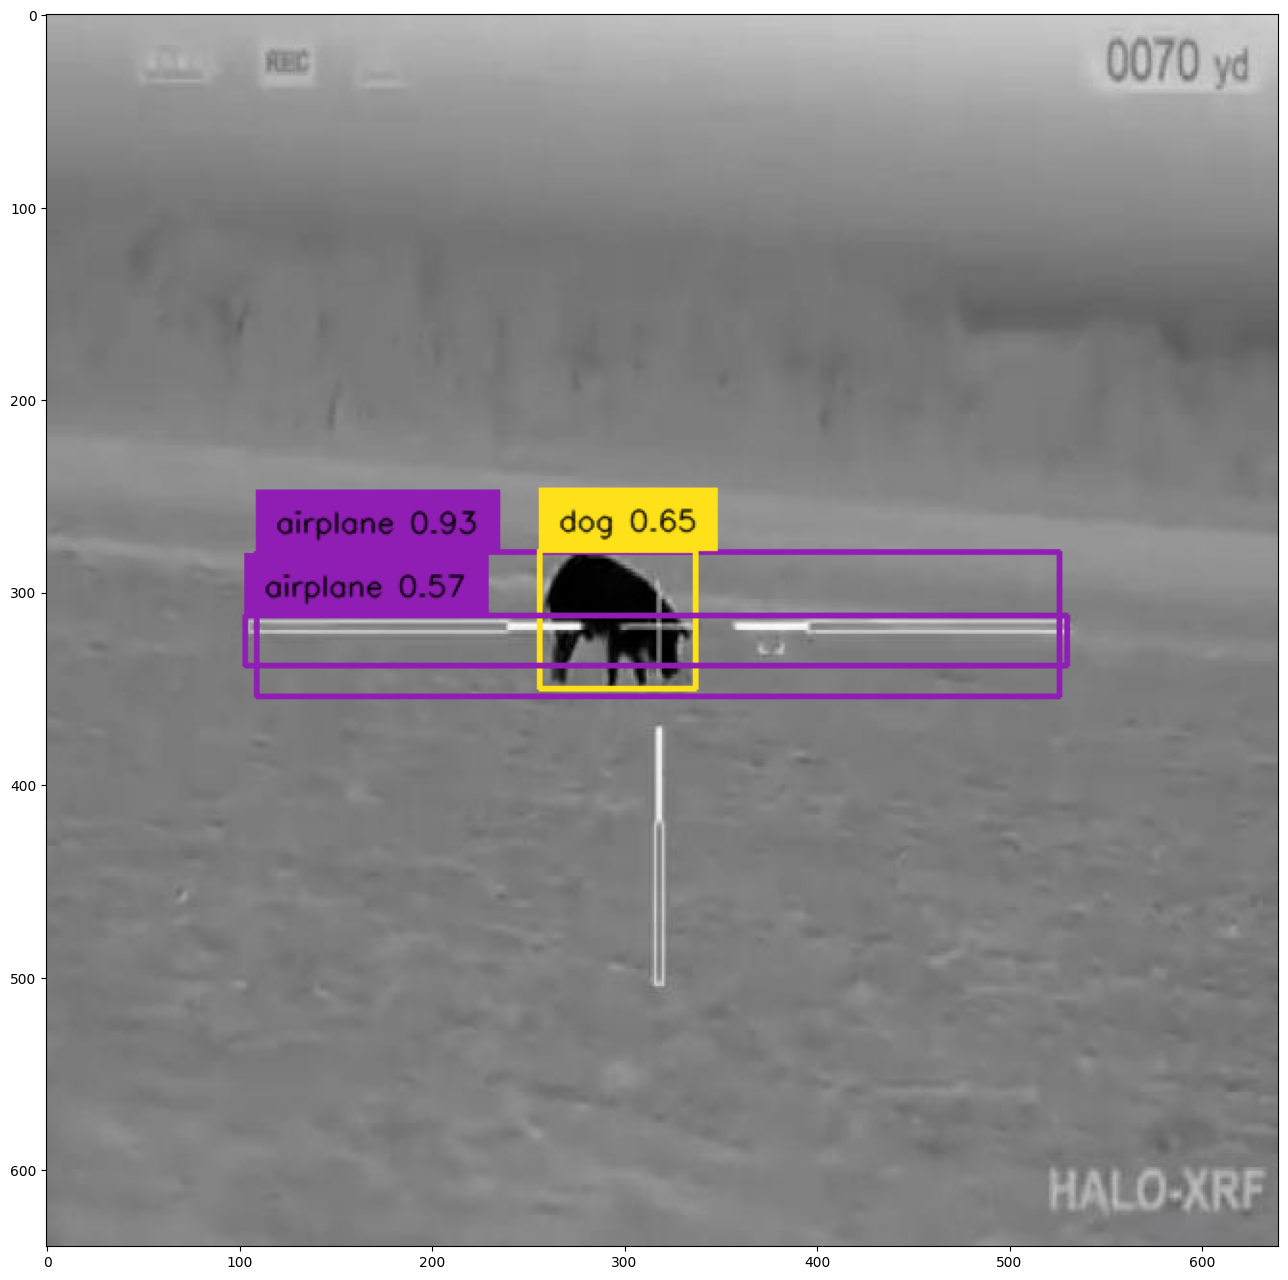

In [ ]:
import cv2
import torch
import supervision as sv


with torch.no_grad():

    # load image and predict
    image = cv2.imread("/content/Thermal-Image-detection-1/test/frame112_png.rf.674a48b3f3d0b6522eed3297d63a1a80.jpg")
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU_TRESHOLD)

labels = [
    f"{model.config.id2label[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

Data Loading

In [ ]:
dataset.location

'/content/Thermal-Image-detection-1'

In [ ]:
import os
import torchvision


# settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset.location, "train")
VAL_DIRECTORY = os.path.join(dataset.location, "valid")
TEST_DIRECTORY = os.path.join(dataset.location, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 1683
Number of validation examples: 70
Number of test examples: 70


verify annotations

Image #320


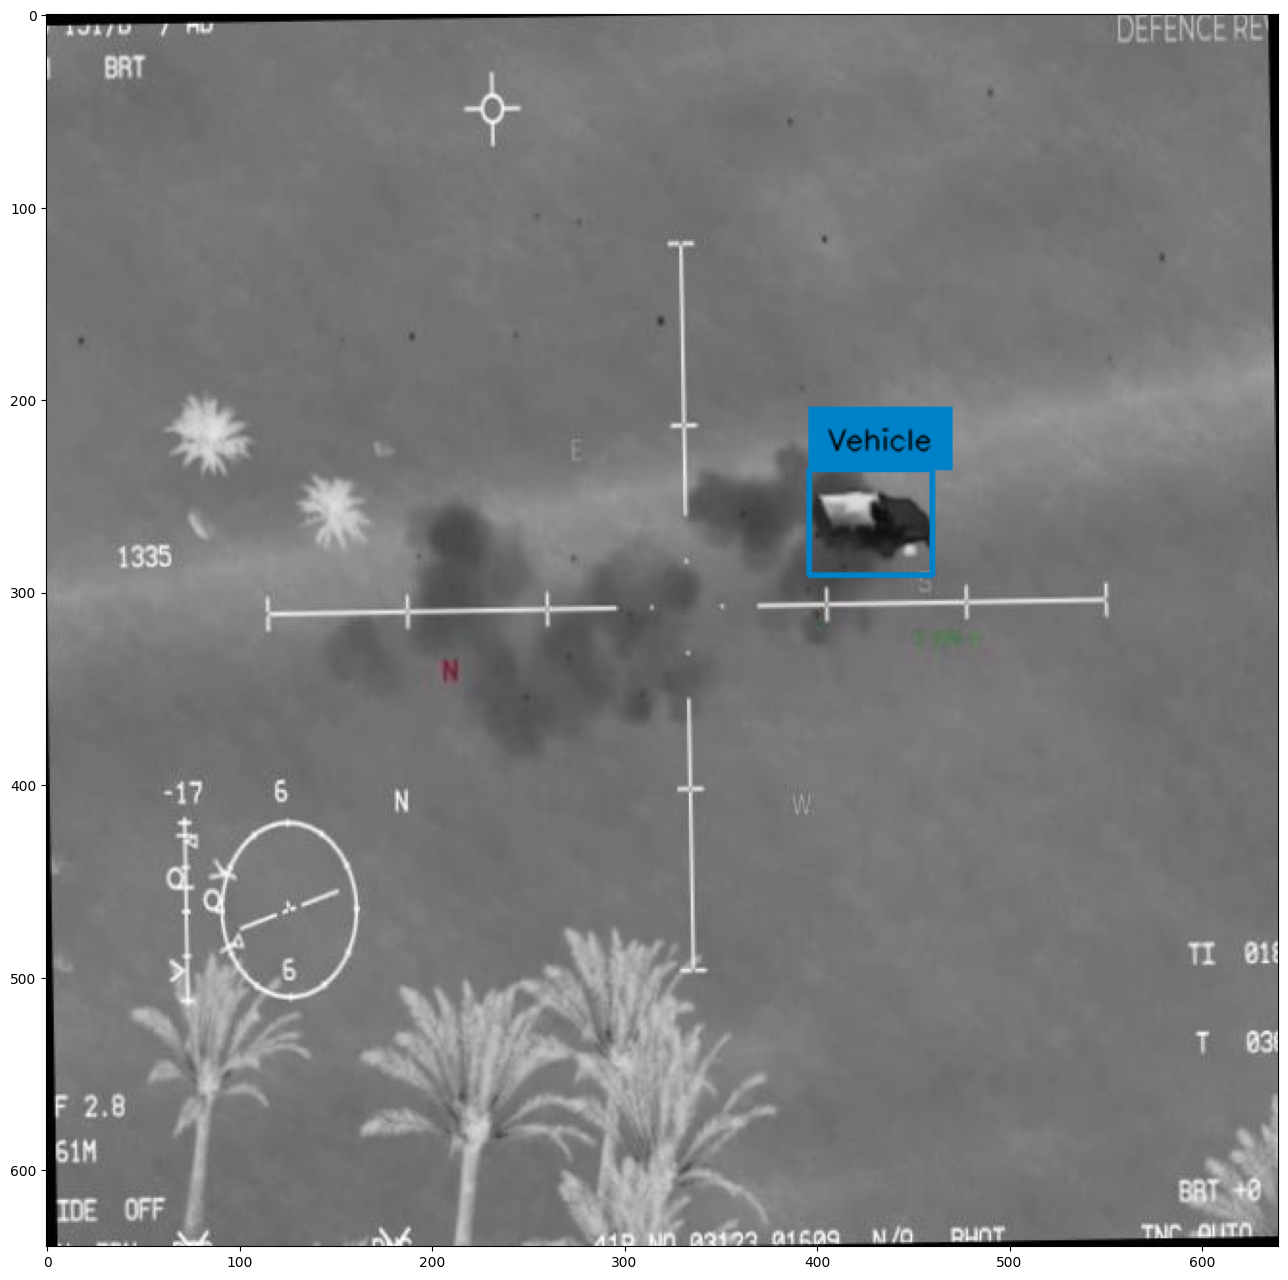

In [ ]:
import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (16, 16))

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

Training

In [ ]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [ ]:
outputs.logits.shape

torch.Size([4, 100, 6])

In [ ]:
from pytorch_lightning import Trainer

# settings
MAX_EPOCHS = 20

# pytorch_lightning < 2.0.0
# trainer = Trainer(gpus=1, max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

# pytorch_lightning >= 2.0.0
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.011   Total estimated model params size (MB)
0         Modules in train mode
399       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Inference on test set image

In [ ]:
model.to(DEVICE)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

Image #2
ground truth


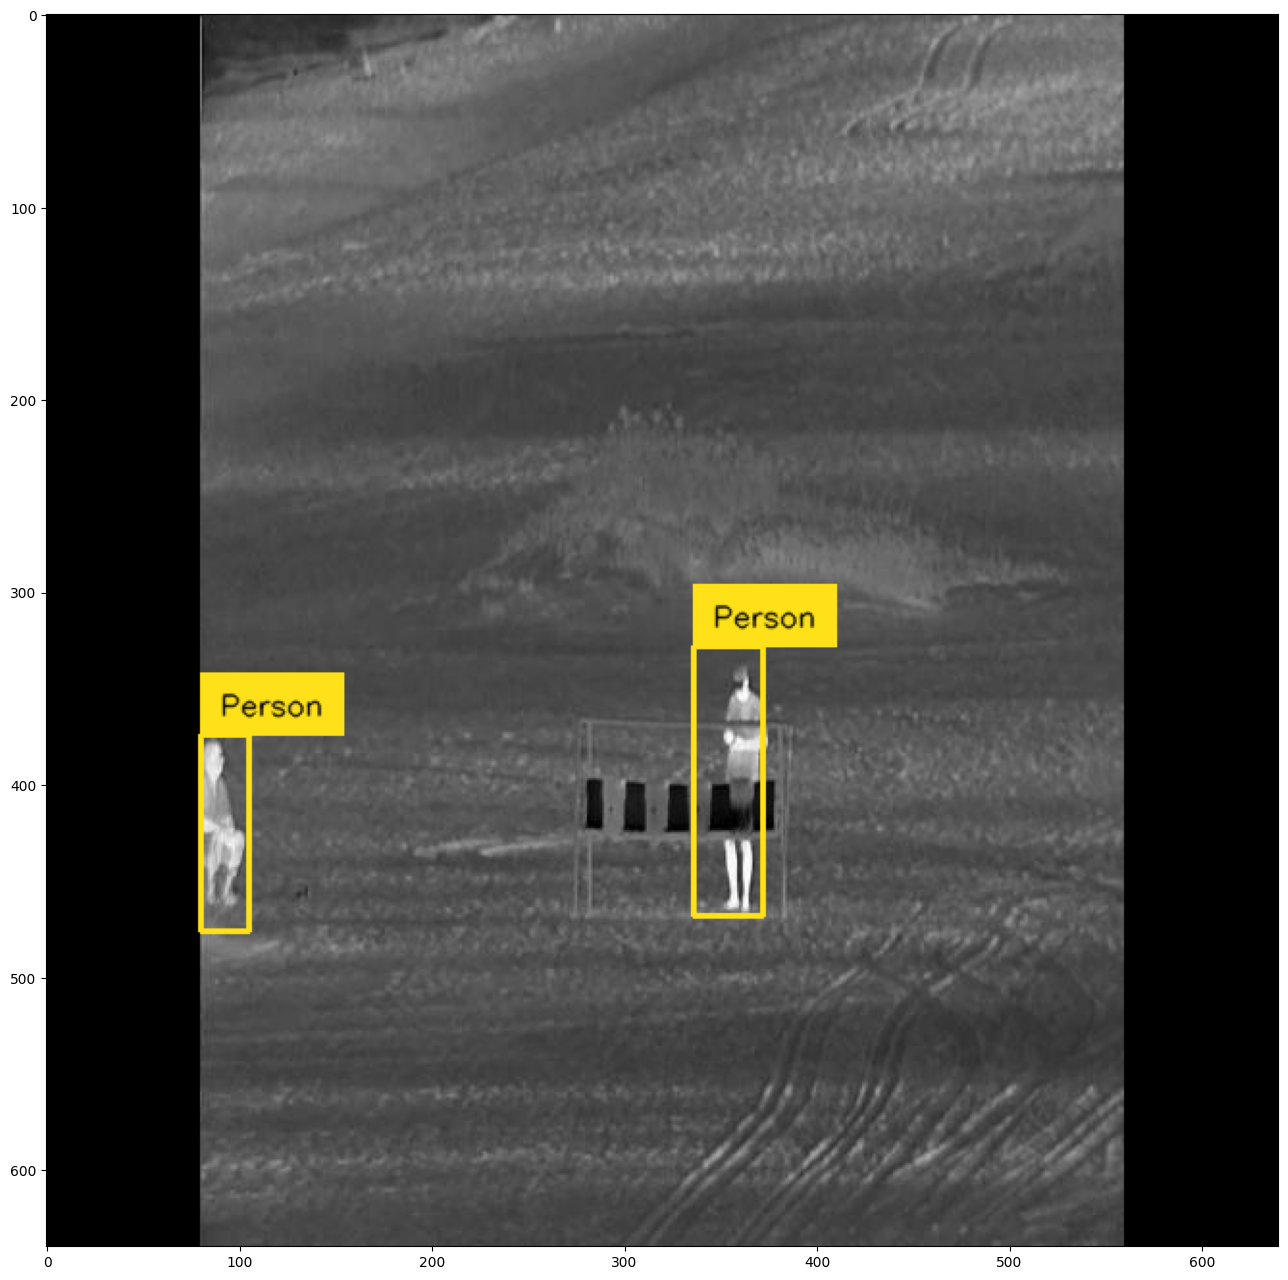

detections


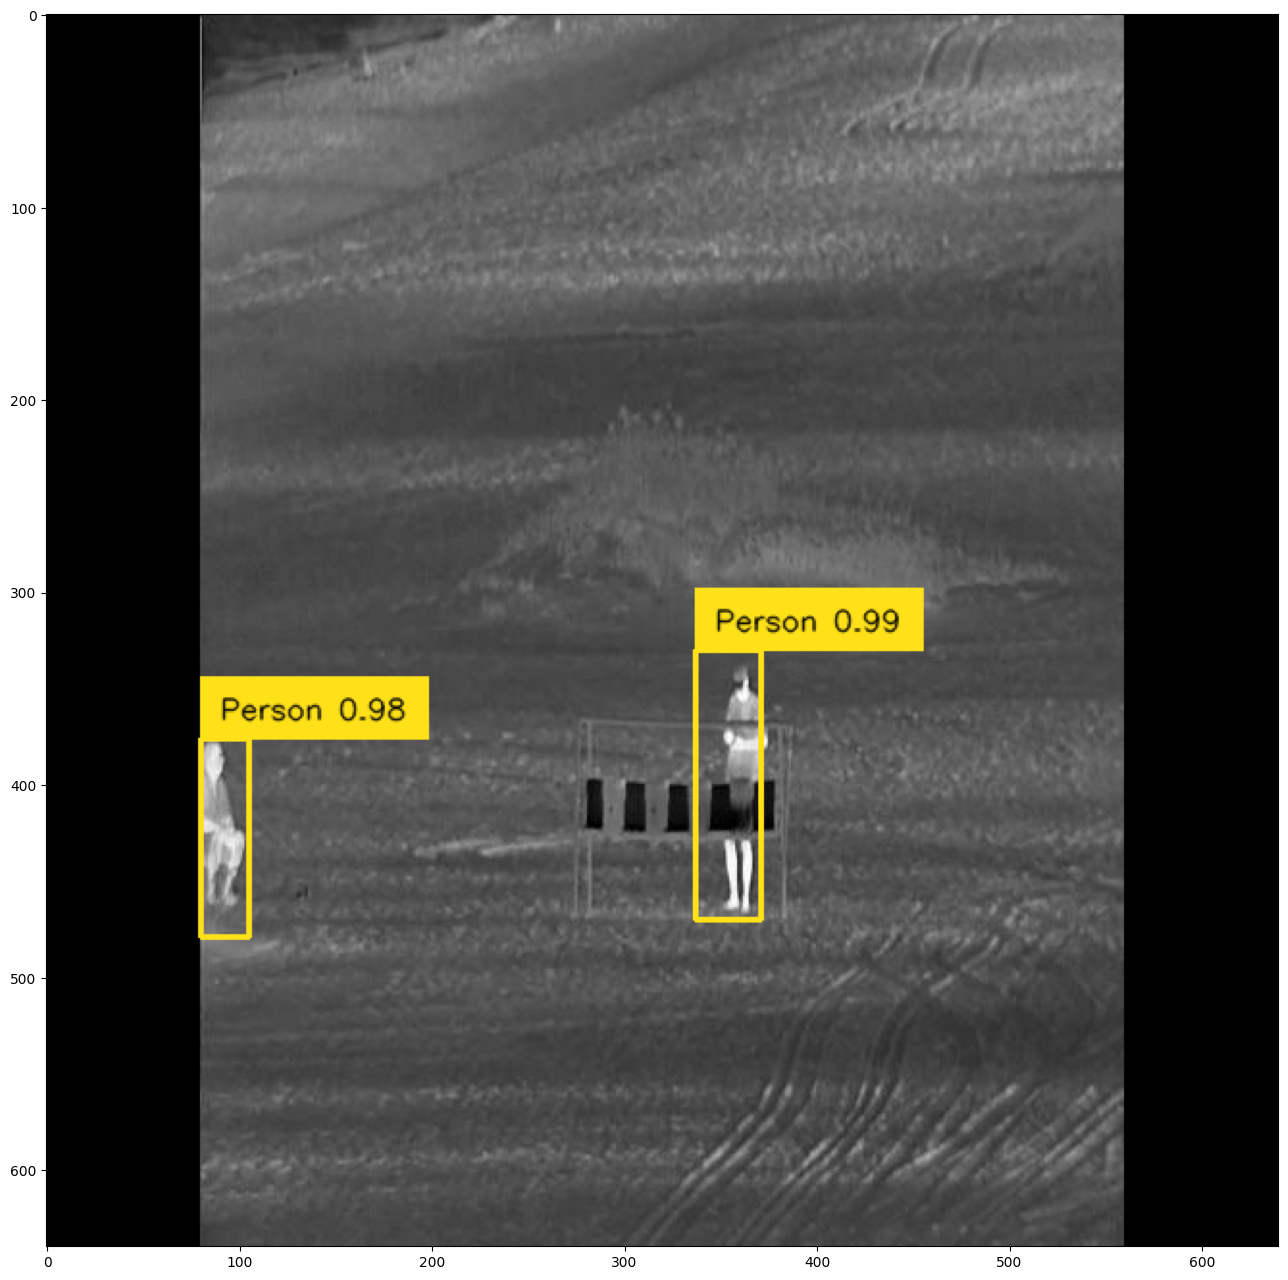

In [ ]:
import random
import cv2
import numpy as np


# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('ground truth')
%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

Evaluating on Test data

In [ ]:
!pip install -q coco_eval

  Preparing metadata (setup.py) ... done


In [ ]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [ ]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/18 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.403
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.597
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.278
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Save the finetuned model

In [ ]:
MODEL_PATH = "/content/custom_model"

In [ ]:
model.model.save_pretrained(MODEL_PATH)

In [ ]:
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.to(DEVICE)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      